In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pmdarima import auto_arima
from tqdm import tqdm

calendrier_challenge = pd.read_parquet("calendrier_challenge.parquet")
questionnaire = pd.read_parquet("questionnaire.parquet")
consos_challenge = pd.read_parquet("consos_challenge.parquet")
temperatures = pd.read_parquet("temperatures.parquet")

min_date = datetime.datetime(2009,7,15)
max_date=datetime.datetime(2011,1,1)
all_clients = list(set(consos_challenge["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
conso_client = consos_challenge.pivot_table(index='horodate', columns='id_client', values='puissance_W', aggfunc='sum')
print(len(all_clients))

615


In [16]:
from sklearn.metrics import mean_squared_error
from statistics import mean

In [2]:
date1 = datetime.datetime(2010, 4, 21) 
date2 = datetime.datetime.strptime('2010-04-22 18:00:00', '%Y-%m-%d %H:%M:%S')
date3 = datetime.datetime.strptime('2010-04-22 21:00:00', '%Y-%m-%d %H:%M:%S')
date4 = datetime.datetime(2010, 4, 23) 

In [3]:
from statsmodels.tsa.stattools import adfuller
# test la stationnarité de la série
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    return dftest[1]

print('P-value de la stationnarité: ',ad_test(conso_client[all_clients[325]]))

P-value de la stationnarité:  9.363653016997921e-26


In [4]:
# Utilise un client random pour les tests
conso_client_0 = conso_client[all_clients[5]]
conso_client_0 = conso_client_0.rename('puissance_W')

In [9]:
from statsmodels.tsa.arima.model import ARIMA

## Création d'un pipeline pour ARIMA 

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def pipeline_SARIMAX(id_client, conso_client=conso_client, date1=date1, date2=date2, date3=date3, date4=date4, p=48, d=1, q=1, s=48):
    # get the power consumption of the client
    conso_client_0 = conso_client[id_client]
    conso_client_0 = conso_client_0.rename('puissance_W')

    # create train and test sets
    train = conso_client_0.loc[(conso_client_0.index < date2) | ((conso_client_0.index < date4) & (conso_client_0.index >= date3))]
    test = conso_client_0.loc[(conso_client_0.index >= date2) & (conso_client_0.index < date3)]

    # train model
    print(0)
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(0,0,0,0)) # did not manage to make it run with seasonal parameters
    print(1)
    model = model.fit()
    print(2)
    # make prediction on test set
    y_pred = model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

    # prepare to plot results
    y_pred.index = test.index
    test = test.to_frame()
    test['prediction'] = y_pred
    
    conso_client_0 = conso_client_0[conso_client_0.index < date4].to_frame().merge(test[['prediction']], how='left', left_index=True, right_index=True)
    
    ax = conso_client_0.loc[(conso_client_0.index > date1) & (conso_client_0.index <= date4)]['puissance_W'].plot(figsize=(15,5), title='Week of data')
    conso_client_0.loc[(conso_client_0.index >= date2) & (conso_client_0.index < date3)]['prediction'].plot(style='-')
    plt.legend(['Truth data', 'Prediction'])
    plt.show()

    rmse = np.sqrt(mean_squared_error(test['puissance_W'], y_pred))
    return rmse

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98090D-01    |proj g|=  8.95259D-02


 This problem is unconstrained.



At iterate    5    f=  7.87195D-01    |proj g|=  7.58614D-02

At iterate   10    f=  7.86419D-01    |proj g|=  1.15850D-03

At iterate   15    f=  7.86416D-01    |proj g|=  5.13870D-04

At iterate   20    f=  7.86409D-01    |proj g|=  1.40985D-03

At iterate   25    f=  7.86283D-01    |proj g|=  7.03007D-03

At iterate   30    f=  7.86100D-01    |proj g|=  1.47993D-02

At iterate   35    f=  7.85904D-01    |proj g|=  1.81201D-03

At iterate   40    f=  7.85836D-01    |proj g|=  1.56493D-03

At iterate   45    f=  7.85830D-01    |proj g|=  1.39026D-04


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.85830D-01    |proj g|=  1.12297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     57      1     0     0   1.123D-05   7.858D-01
  F =  0.78583025561680786     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


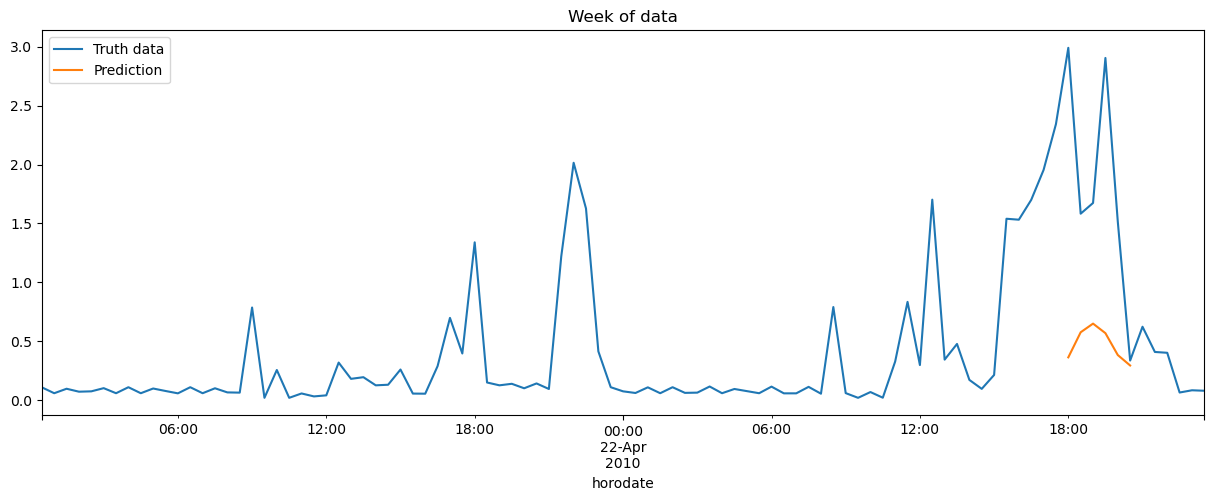

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51078D-01    |proj g|=  8.16911D-02

At iterate    5    f=  5.46075D-01    |proj g|=  1.92987D-02

At iterate   10    f=  5.45803D-01    |proj g|=  3.45927D-03

At iterate   15    f=  5.45671D-01    |proj g|=  1.58038D-03

At iterate   20    f=  5.45661D-01    |proj g|=  3.08840D-04

At iterate   25    f=  5.45660D-01    |proj g|=  2.71236D-04

At iterate   30    f=  5.45660D-01    |proj g|=  1.67713D-04

At iterate   35    f=  5.45658D-01    |proj g|=  1.29820D-03

At iterate   40    f=  5.45612D-01    |proj g|=  4.58369D-03

At iterate   45    f=  5.45532D-01    |proj g|=  3.41195D-03


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.45473D-01    |proj g|=  3.59725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     60      1     0     0   3.597D-03   5.455D-01
  F =  0.54547286831491759     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


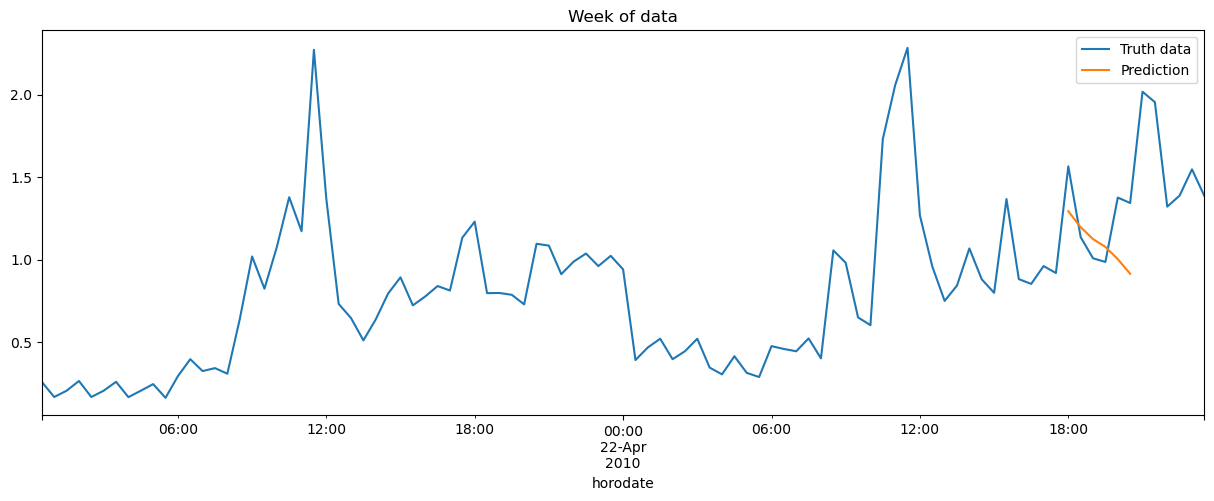

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35420D-01    |proj g|=  1.80792D-01


 This problem is unconstrained.



At iterate    5    f=  8.00044D-01    |proj g|=  3.11547D-02

At iterate   10    f=  7.93693D-01    |proj g|=  2.47996D-02

At iterate   15    f=  7.91560D-01    |proj g|=  3.40431D-03

At iterate   20    f=  7.91531D-01    |proj g|=  4.41709D-03

At iterate   25    f=  7.91325D-01    |proj g|=  1.01900D-02

At iterate   30    f=  7.90982D-01    |proj g|=  1.20938D-02

At iterate   35    f=  7.90780D-01    |proj g|=  3.51370D-03

At iterate   40    f=  7.90720D-01    |proj g|=  8.00129D-04

At iterate   45    f=  7.90714D-01    |proj g|=  1.35398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     48     54   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


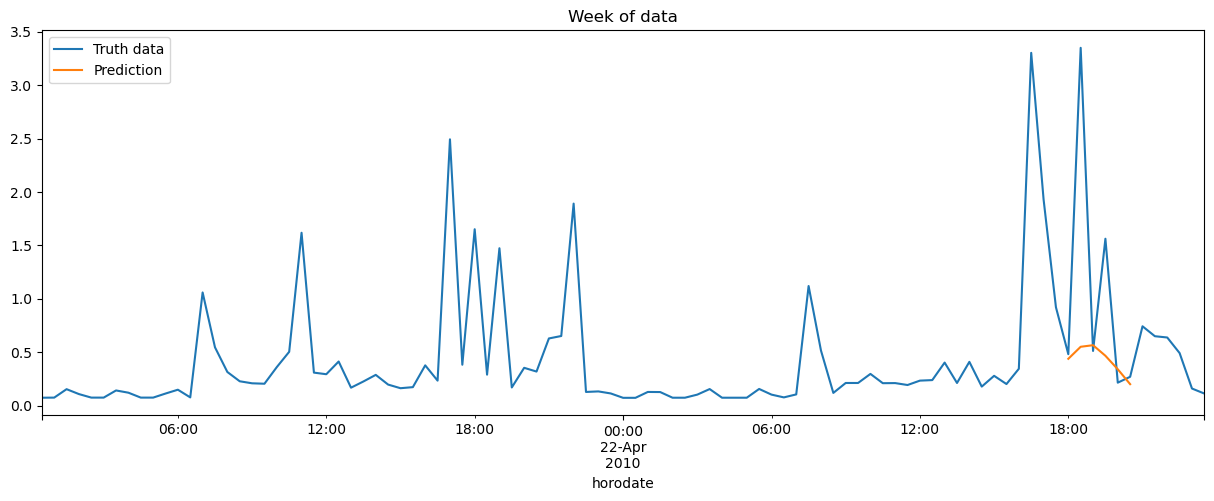

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75597D-01    |proj g|=  1.06780D+00


 This problem is unconstrained.



At iterate    5    f=  7.66010D-02    |proj g|=  6.60007D-02

At iterate   10    f=  6.29504D-02    |proj g|=  3.76858D-02

At iterate   15    f=  4.64685D-02    |proj g|=  1.22094D-01

At iterate   20    f=  3.77362D-02    |proj g|=  8.45076D-02

At iterate   25    f=  3.61726D-02    |proj g|=  1.33482D-02

At iterate   30    f=  3.50423D-02    |proj g|=  2.09994D-02

At iterate   35    f=  3.48125D-02    |proj g|=  2.98284D-03

At iterate   40    f=  3.47781D-02    |proj g|=  1.56626D-02

At iterate   45    f=  3.46786D-02    |proj g|=  2.09732D-02

At iterate   50    f=  3.45485D-02    |proj g|=  4.96027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


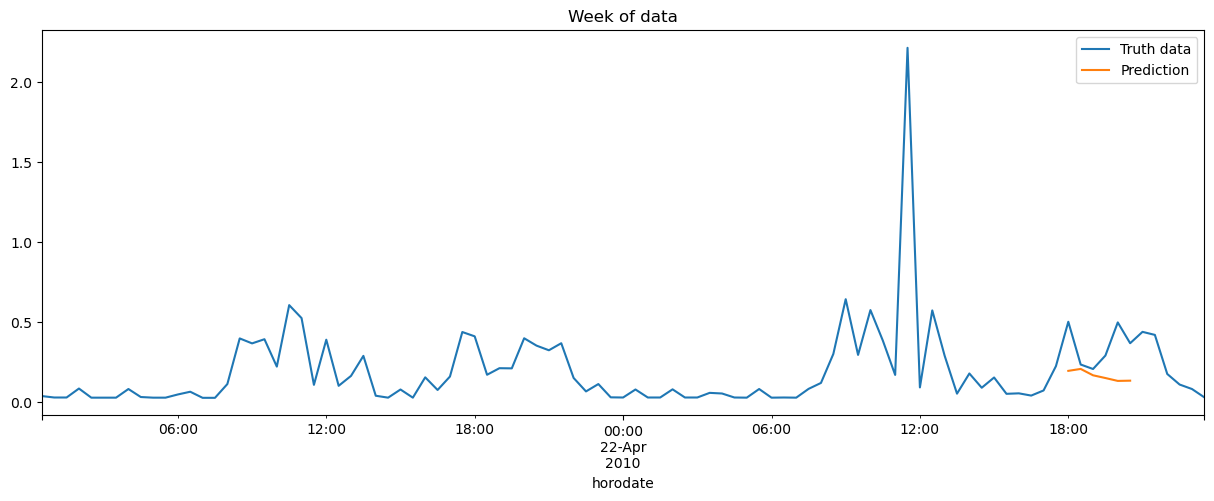

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.41222D-01    |proj g|=  3.33574D-01

At iterate    5    f= -5.54665D-01    |proj g|=  2.37761D-01

At iterate   10    f= -5.63009D-01    |proj g|=  5.43919D-02

At iterate   15    f= -5.64760D-01    |proj g|=  1.66689D-02

At iterate   20    f= -5.65064D-01    |proj g|=  2.72020D-02

At iterate   25    f= -5.65138D-01    |proj g|=  1.33792D-02

At iterate   30    f= -5.65172D-01    |proj g|=  3.78152D-03

At iterate   35    f= -5.65186D-01    |proj g|=  3.93751D-03

At iterate   40    f= -5.65197D-01    |proj g|=  3.45022D-03

At iterate   45    f= -5.65254D-01    |proj g|=  1.05141D-02


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.65497D-01    |proj g|=  4.29608D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     58      1     0     0   4.296D-02  -5.655D-01
  F = -0.56549745773837512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


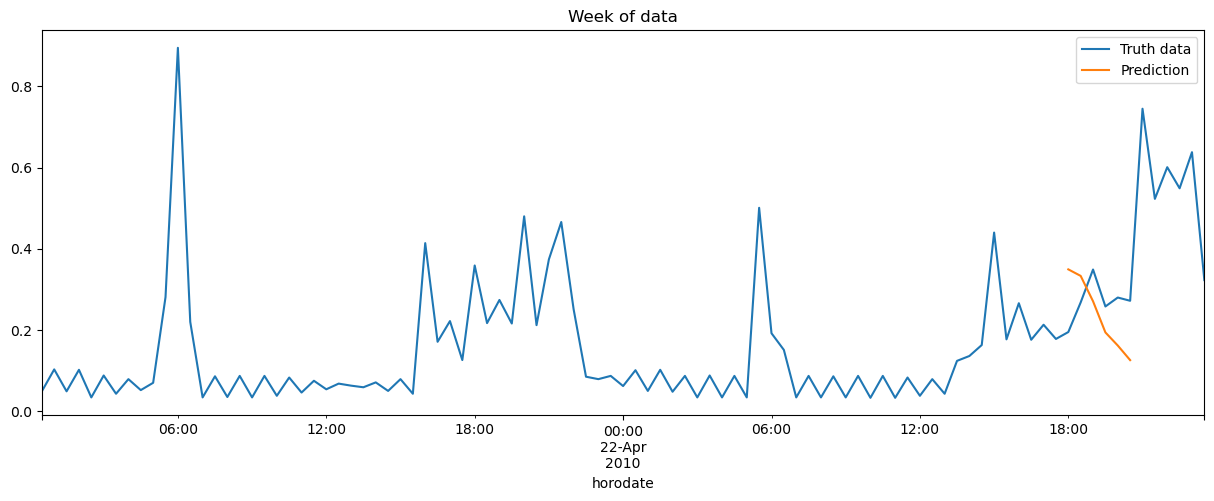

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58526D-01    |proj g|=  1.28864D-01


 This problem is unconstrained.



At iterate    5    f=  7.43907D-01    |proj g|=  1.28852D-02

At iterate   10    f=  7.43121D-01    |proj g|=  6.83796D-03

At iterate   15    f=  7.43093D-01    |proj g|=  1.29349D-03

At iterate   20    f=  7.42796D-01    |proj g|=  8.52365D-03

At iterate   25    f=  7.42455D-01    |proj g|=  1.36554D-02

At iterate   30    f=  7.42397D-01    |proj g|=  2.71956D-03

At iterate   35    f=  7.42385D-01    |proj g|=  2.12987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     37     41      1     0     0   1.599D-05   7.424D-01
  F =  0.74238530719354501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


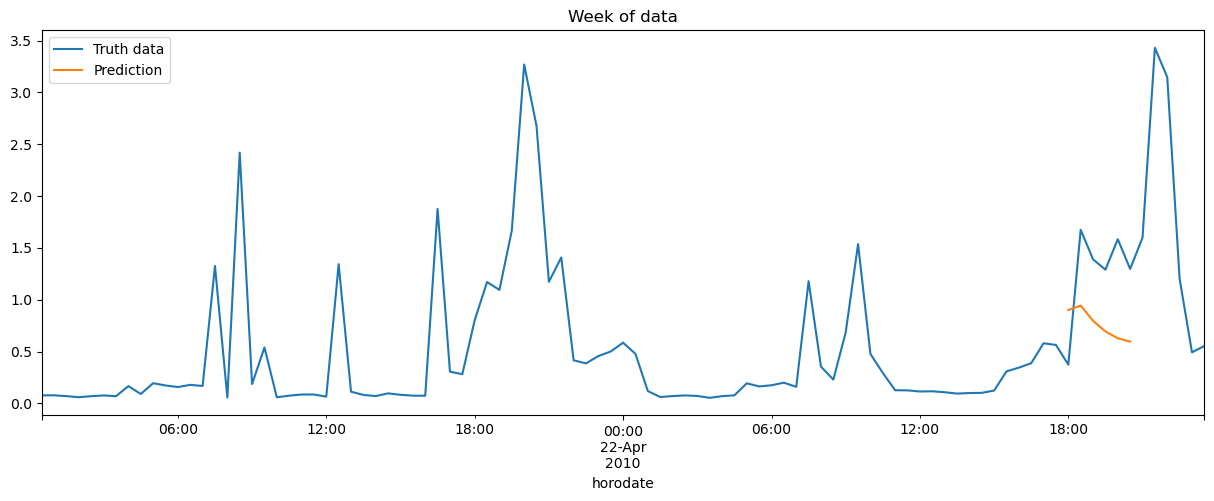

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42368D-01    |proj g|=  1.54887D-01

At iterate    5    f=  9.22797D-01    |proj g|=  2.52884D-02

At iterate   10    f=  9.17174D-01    |proj g|=  1.35413D-02

At iterate   15    f=  9.16845D-01    |proj g|=  1.74071D-03

At iterate   20    f=  9.16835D-01    |proj g|=  5.64570D-04

At iterate   25    f=  9.16834D-01    |proj g|=  8.49261D-05

At iterate   30    f=  9.16834D-01    |proj g|=  1.20681D-04

At iterate   35    f=  9.16831D-01    |proj g|=  1.02996D-03

At iterate   40    f=  9.16812D-01    |proj g|=  9.82884D-04

At iterate   45    f=  9.16787D-01    |proj g|=  1.15838D-03


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.16771D-01    |proj g|=  6.41802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     61      1     0     0   6.418D-04   9.168D-01
  F =  0.91677066309729727     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


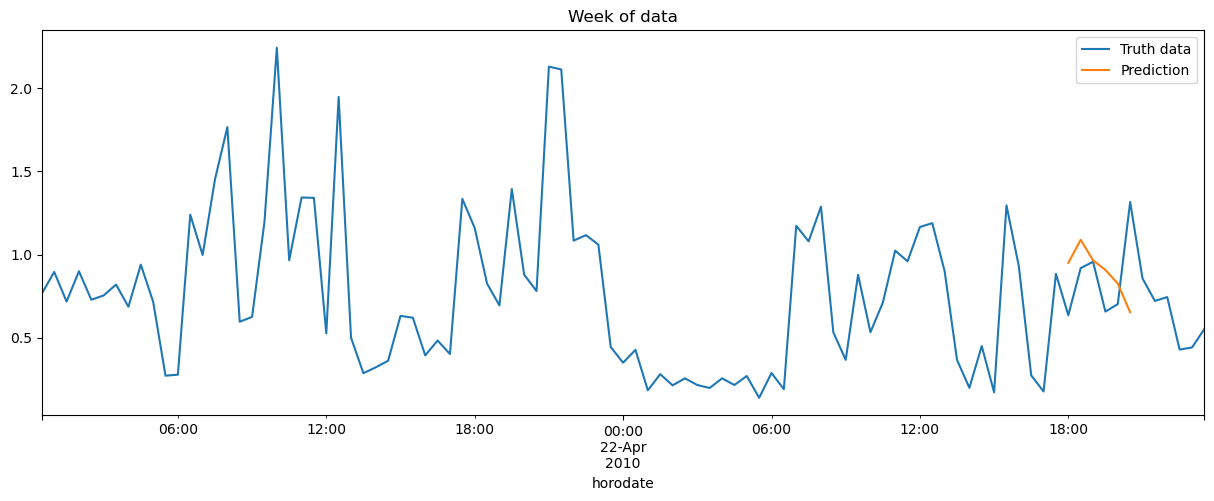

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01833D+00    |proj g|=  1.02980D-01

At iterate    5    f=  1.01160D+00    |proj g|=  1.93132D-02

At iterate   10    f=  1.01082D+00    |proj g|=  4.93410D-03

At iterate   15    f=  1.01067D+00    |proj g|=  1.04516D-03

At iterate   20    f=  1.01066D+00    |proj g|=  3.55528D-04

At iterate   25    f=  1.01066D+00    |proj g|=  3.52459D-05

At iterate   30    f=  1.01066D+00    |proj g|=  1.87488D-04

At iterate   35    f=  1.01066D+00    |proj g|=  1.41100D-04

At iterate   40    f=  1.01066D+00    |proj g|=  8.29912D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


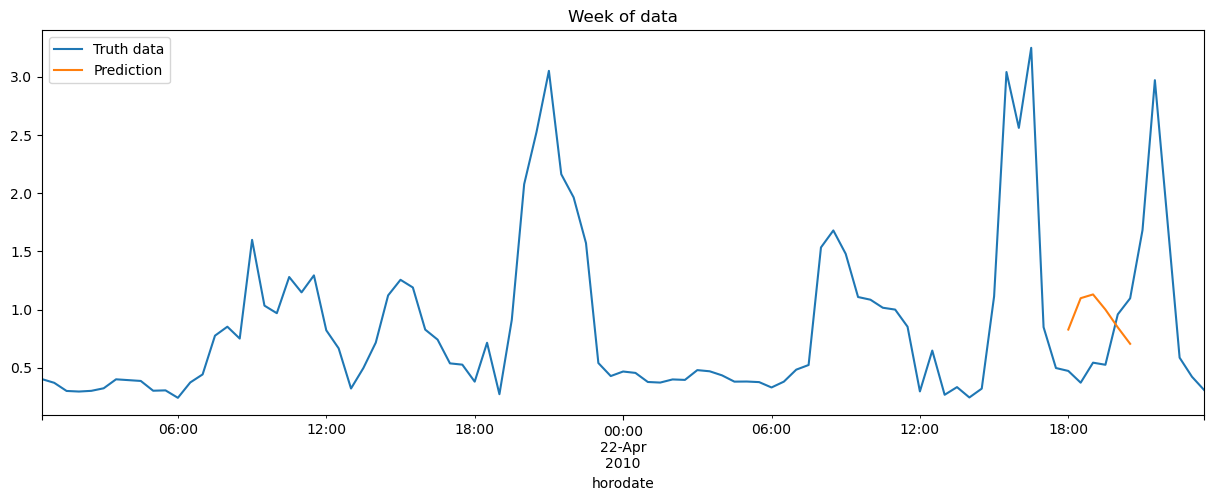

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25863D-02    |proj g|=  8.45700D-02


 This problem is unconstrained.



At iterate    5    f=  4.33762D-03    |proj g|=  4.02400D-02

At iterate   10    f=  3.37641D-03    |proj g|=  2.20116D-03

At iterate   15    f=  3.36657D-03    |proj g|=  5.81162D-04

At iterate   20    f=  3.36118D-03    |proj g|=  8.47028D-04

At iterate   25    f=  3.25603D-03    |proj g|=  5.81589D-03

At iterate   30    f=  2.97300D-03    |proj g|=  3.75677D-03

At iterate   35    f=  2.84057D-03    |proj g|=  2.70136D-03

At iterate   40    f=  2.78213D-03    |proj g|=  1.53238D-03

At iterate   45    f=  2.75943D-03    |proj g|=  1.08943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     49     57   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


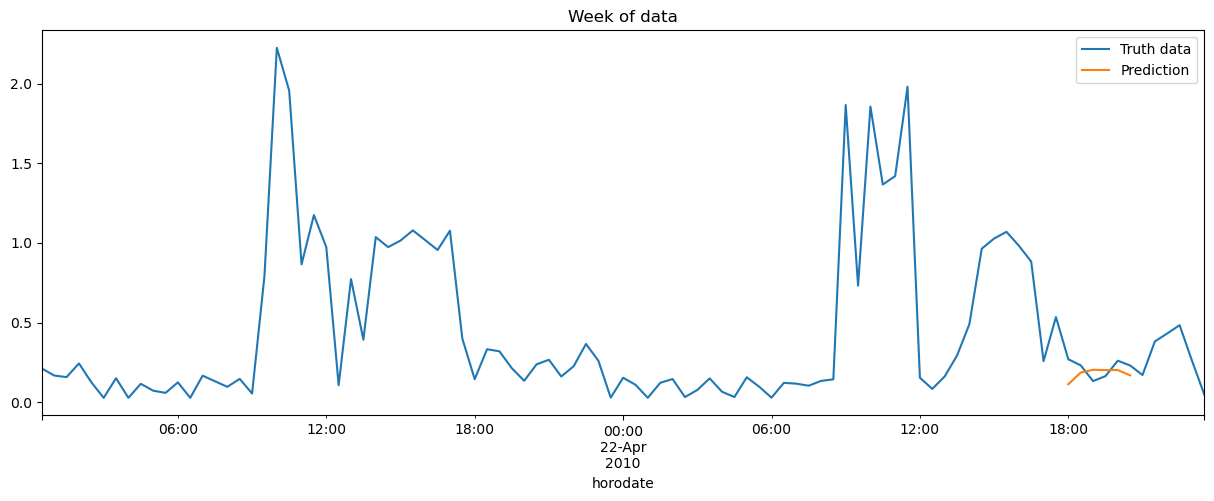

0
1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10942D-01    |proj g|=  1.20649D-01

At iterate    5    f=  6.94971D-01    |proj g|=  1.74656D-02

At iterate   10    f=  6.94069D-01    |proj g|=  9.06855D-04

At iterate   15    f=  6.93999D-01    |proj g|=  3.20355D-03

At iterate   20    f=  6.93232D-01    |proj g|=  1.15691D-02

At iterate   25    f=  6.92109D-01    |proj g|=  7.83631D-03

At iterate   30    f=  6.91617D-01    |proj g|=  3.18517D-03

At iterate   35    f=  6.90987D-01    |proj g|=  9.52137D-03

At iterate   40    f=  6.89286D-01    |proj g|=  9.83130D-03

At iterate   45    f=  6.88529D-01    |proj g|=  3.97903D-03


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.88422D-01    |proj g|=  2.65205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     58      1     0     0   2.652D-04   6.884D-01
  F =  0.68842197332639388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


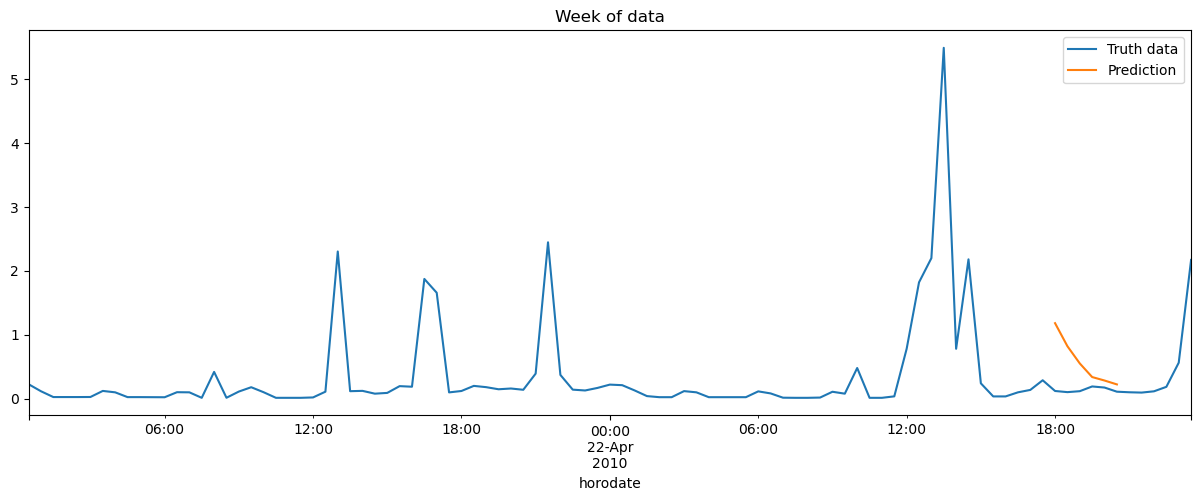

TypeError: can't convert type 'NoneType' to numerator/denominator

In [17]:
liste_rmse = []
for i in range(10):
    liste_rmse.append(pipeline_SARIMAX(all_clients[i]))
print(f"RMSE moyen des prédictions: {mean(liste_rmse)}")